In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool

from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.io as io

In [2]:
def outlier_plot(ax, fc_list, plot_x_val, plot_y_val, outlier_idx, plot_idx, color):
    outlier_fc = np.array([])
    outlier_y_val = np.array([])
    outlier_x_val = np.array([])
        
    idx = np.intersect1d(plot_idx, outlier_idx)
    for j in idx:
        if fc_list[j] > 1:
            outlier_fc = np.append(outlier_fc, get_fc_range(fc_list[j]))
        else:
            outlier_fc = np.append(outlier_fc, get_fc_range(1/fc_list[j]))
            
        outlier_x_val = np.append(outlier_x_val, plot_x_val[j])
        outlier_y_val = np.append(outlier_y_val, plot_y_val[j])
        
    ax.scatter(outlier_x_val, outlier_y_val,
               color=color,
               s=outlier_fc,
               marker='o',
               edgecolor='w')

def get_fc_range(val):
    if (val >= 4):
        fc_range = 200
    elif (val >= 2):
        fc_range = 100
    else:
        fc_range = 50
    return fc_range

In [3]:
length_list = [0, 248956422, 491149951, 689445510, 879660065, 1061198324,
               1232004303, 1391350276, 1536488912, 1674883629, 1808681051,
               1943767673, 2077042982, 2191407310, 2298451028, 2400442217,
               2490780562, 2574038003, 2654411288, 2713028904, 2777473071,
               2824183054, 2875001522, 3031042417]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']

v2_FILE = '/project/GCRB/Hon_lab/shared/former_members/s160875/03.analysis/Mosaic-seq/CROP-DE-analysis_10X-66K_no_downsampling-CPM.hg38/\
combine_10sgRNAs-volcano/generate_annotations/plot_annotation.txt'

annot_df = pd.read_csv(v2_FILE,
        header = None,
        sep='\t',
        names = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx'])

In [4]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 'chr_idx', 
                    'region', 'distance', 'num_cell', 'bin', 'pval', 'fc', 
                    'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [5]:
MB361_local_hits = pd.read_csv('./MB361-filter_local_df.csv')[local_df_columns]
MB231_local_hits = pd.read_csv('./MB231-filter_local_df.csv')[local_df_columns]

In [6]:
global_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 'color_idx', 
                     'chr_idx', 'region', 'num_cell', 'bin', 'pval', 'fc', 
                     'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [7]:
MB361_global_hits = pd.read_csv('./MB361-expressed_global_hit.csv')[global_df_columns]
MB231_global_hits = pd.read_csv('./MB231-expressed_global_hit.csv')[global_df_columns]

In [8]:
common_global_hits = set(MB361_global_hits['region']).intersection(set(MB231_global_hits['region']))

In [9]:
len(common_global_hits)

2190

## Global hits overlap
____

In [46]:
cell_line_global_overlap_rate_df = pd.DataFrame(data=None, index=common_global_hits, 
                                      columns=common_global_hits)

cell_line_global_overlap_num_df = pd.DataFrame(data=None, index=common_global_hits, 
                                      columns=common_global_hits)

for i in common_global_hits:
    genes_361 = MB361_global_hits[MB361_global_hits['region'] == i]['gene_names'].values
    for j in common_global_hits:
        genes_231 = MB231_global_hits[MB231_global_hits['region'] == j]['gene_names'].values
        num_overlap_genes = len(set(genes_361).intersection(set(genes_231)))
        total_num_genes = len(genes_361) + len(genes_231) - num_overlap_genes
        if total_num_genes == 0:
            overlap_rate = 0
        else:
            overlap_rate = num_overlap_genes / total_num_genes

        cell_line_global_overlap_rate_df.loc[j, i] = overlap_rate
        
        cell_line_global_overlap_num_df.loc[j, i] = num_overlap_genes
        
cell_line_global_overlap_rate_df.to_csv('./Cell_lines_comp_overlap_rate.csv')
cell_line_global_overlap_num_df.to_csv('./Cell_lines_comp_overlap_num.csv')

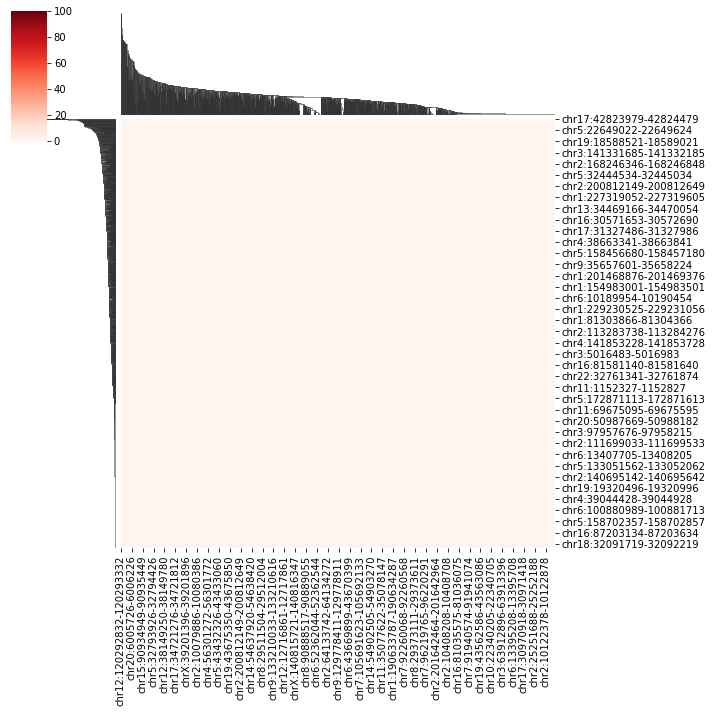

In [51]:
import seaborn as sns 
cell_line_global_overlap_df = pd.read_csv('./Cell_lines_comp_overlap_rate.csv', index_col=0)
g = sns.clustermap(cell_line_global_overlap_df.astype(float), vmax=100, cmap='Reds')
plt.savefig('./figures/cell_lines_overlap_rate.png', dpi=600)

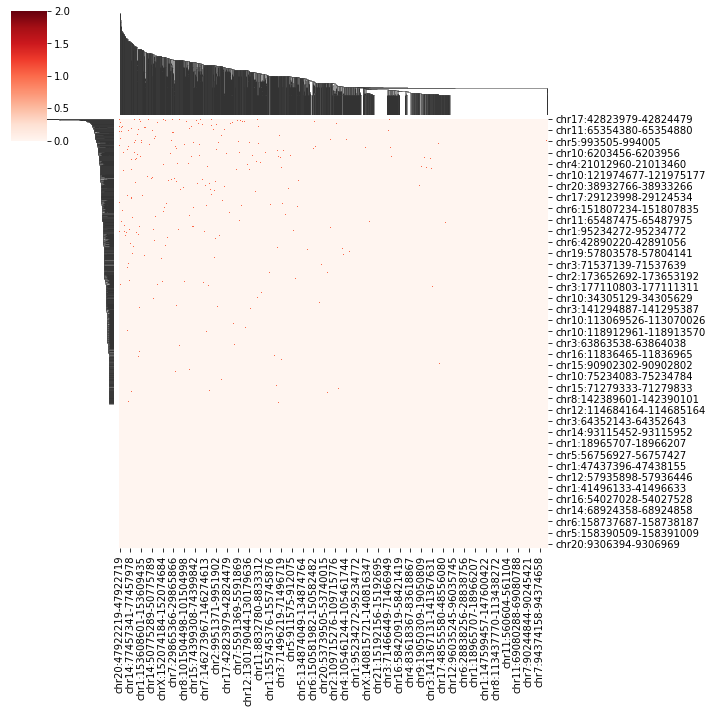

In [53]:
import seaborn as sns 
cell_line_global_overlap_df = pd.read_csv('./Cell_lines_comp_overlap_num.csv', index_col=0)
g = sns.clustermap(cell_line_global_overlap_df.astype(float), vmax=2, cmap='Reds')
#plt.savefig('./figures/cell_lines_overlap_num.png', dpi=600)

In [55]:
cell_line_global_overlap_df.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_row.reordered_ind].iloc[:20, :20]

,chr17:42823979-42824479,chr9:133375050-133375583,chr22:23838946-23839573,chr3:45054447-45055020,chr16:57014561-57015061,chr6:140043962-140044480,chr3:124564875-124565462,chr10:90930248-90930748,chr15:96317148-96317648,chr11:320278-320778,chr10:25493403-25494023,chr12:93784320-93784914,chr6:28944297-28944852,chr8:97090417-97090975,chr1:151198159-151198753,chr2:42132890-42133472,chr20:56789126-56789626,chr6:109343510-109344022,chr7:15555494-15555994,chr1:76868134-76868634
chr17:42823979-42824479,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
chr9:133375050-133375583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr22:23838946-23839573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr3:45054447-45055020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
chr16:57014561-57015061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr6:140043962-140044480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr3:124564875-124565462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr10:90930248-90930748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr15:96317148-96317648,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr11:320278-320778,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [45]:
MB361_global_hits[MB361_global_hits['region'] == 'chr2:42132890-42133472']

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
2683,51958,PANK2,chr20,2716917743,+,1,19,chr2:42132890-42133472,1131,1100,-2.427730,0.836916,-61.902571,0.792627
2684,27801,EXOSC2,chr9,1667182633,+,0,8,chr2:42132890-42133472,1131,1100,-1.245209,0.893566,-235.669338,0.795677
2685,11537,RAP2B,chr3,644312221,+,0,2,chr2:42132890-42133472,1131,1100,-5.206490,0.746267,-234.613317,0.730555


In [44]:
MB231_global_hits[MB231_global_hits['region'] == 'chr2:140643735-140644235']

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
9086,34919,ORMDL2,chr12,1999585592,+,1,11,chr2:140643735-140644235,861,900,-1.833559,0.811177,-62.726464,0.770806
9087,55158,C22orf46,chr22,2865871993,+,1,21,chr2:140643735-140644235,861,900,-4.086624,0.690631,-55.610695,0.696078


In [47]:
cell_line_global_overlap_df.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_row.reordered_ind].iloc[:10, :10]

,chr9:133375050-133375583,chr22:23838946-23839573,chr17:42823979-42824479,chr16:57014561-57015061,chr6:140043962-140044480,chr11:320278-320778,chr3:45054447-45055020,chr12:93784320-93784914,chr2:42132890-42133472,chr6:10189954-10190454
chr9:133375050-133375583,0,0,0,0,0,0,0,0,0,0
chr22:23838946-23839573,0,0,0,0,0,0,0,0,0,0
chr17:42823979-42824479,0,0,0,0,0,0,0,0,0,0
chr16:57014561-57015061,0,0,0,0,0,0,0,0,0,0
chr6:140043962-140044480,0,0,0,0,0,0,0,0,0,0
chr11:320278-320778,0,0,0,0,0,1,0,0,0,0
chr3:45054447-45055020,0,0,0,0,0,0,0,0,0,0
chr12:93784320-93784914,0,0,0,0,0,0,0,0,0,0
chr2:42132890-42133472,0,0,0,0,0,0,0,0,0,0
chr6:10189954-10190454,0,0,0,0,0,0,0,0,0,0


## Identify cell line specific enhancers
_____

In [52]:
MB231_local_freq = collections.Counter(list(MB231_GWAS_local_hits['gene_names'].values) + list(MB231_SM_local_hits['gene_names'].values))

In [53]:
MB361_local_freq = collections.Counter(MB361_local_hits['gene_names'])

In [ ]:
for i in set(MB361_local_freq.keys()).intersection(set(MB231_local_freq.keys())):
    print(i)
    print(MB361_local_hits[MB361_local_hits['gene_names'] == i]['region'].values)
    print(MB231_GWAS_local_hits[MB231_GWAS_local_hits['gene_names'] == i]['region'].values)
    print(MB231_SM_local_hits[MB231_SM_local_hits['gene_names'] == i]['region'].values)

## Gene based Manhattan plot (combine two cell lines)
_____

In [14]:
All_regions = list(set(MB361_global_hits['region'].values).union(set(MB231_global_hits['region'].values)))

In [33]:
cancer_gene = ['ABI1', 'ABL1', 'ABL2', 'ACKR3', 'ACSL3', 'ACVR1', 'ACVR1B', 'ACVR2A', 'AFDN', 'AFF1', 'AFF3',
               'AFF4', 'AKT1', 'AKT2', 'ALK', 'AMER1', 'APC', 'APOBEC3B', 'AR', 'ARHGAP26', 'ARHGAP35', 'ARHGEF12',
               'ARID1A', 'ARID1B', 'ARID2', 'ARNT', 'ASPSCR1', 'ASXL1', 'ATF1', 'ATIC', 'ATM', 'ATP1A1', 'ATP2B3',
               'ATR', 'ATRX', 'AXIN1', 'AXIN2', 'B2M', 'BAP1', 'BARD1', 'BAX', 'BCL10', 'BCL11A', 'BCL11B', 'BCL2',
               'BCL3', 'BCL6', 'BCL7A', 'BCL9', 'BCL9L', 'BCOR', 'BCORL1', 'BCR', 'BIRC3', 'BLM', 'BMPR1A', 'BRAF',
               'BRCA1', 'BRCA2', 'BRD3', 'BRD4', 'BRIP1', 'BTG1', 'BTK', 'BUB1B', 'CACNA1D', 'CALR', 'CAMTA1', 'CANT1',
               'CARD11', 'CARS', 'CASP8', 'CBFA2T3', 'CBFB', 'CBL', 'CBLB', 'CBLC', 'CCDC6', 'CCNB1IP1', 'CCND1', 'CCND2',
               'CCND3', 'CCNE1', 'CD274', 'CD74', 'CD79A', 'CD79B', 'CDC73', 'CDH1', 'CDH11', 'CDK12', 'CDK4', 'CDK6', 
               'CDKN1B', 'CDKN2A', 'CDKN2C', 'CDX2', 'CEBPA', 'CHCHD7', 'CHD4', 'CHEK2', 'CIC', 'CIITA', 'CLIP1', 'CLTC',
               'CLTCL1', 'CNBP', 'CNOT3', 'CNTRL', 'COL1A1', 'COL2A1', 'CREB1', 'CREB3L1', 'CREB3L2', 'CREBBP', 'CRLF2',
               'CRTC1', 'CRTC3', 'CSF3R', 'CTCF', 'CTNNB1', 'CUX1', 'CXCR4', 'CYLD', 'DAXX', 'DCTN1', 'DDB2', 'DDIT3',
               'DDR2', 'DDX10', 'DDX3X', 'DDX5', 'DDX6', 'DEK', 'DICER1', 'DNAJB1', 'DNM2', 'DNMT3A', 'DROSHA', 'EBF1',
               'EGFR', 'EIF3E', 'EIF4A2', 'ELF4', 'ELK4', 'ELL', 'EML4', 'EP300', 'EPAS1', 'EPS15', 'ERBB2', 'ERBB3',
               'ERBB4', 'ERC1', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERG', 'ESR1', 'ETNK1', 'ETV1', 'ETV4', 'ETV5',
               'ETV6', 'EWSR1', 'EXT1', 'EXT2', 'EZH2', 'EZR', 'FANCA', 'FANCC', 'FANCD2', 'FANCE', 'FANCF', 'FANCG',
               'FAS', 'FAT1', 'FAT4', 'FBXO11', 'FBXW7', 'FCGR2B', 'FCRL4', 'FES', 'FEV', 'FGFR1', 'FGFR1OP', 'FGFR2',
               'FGFR3', 'FGFR4', 'FH', 'FHIT', 'FIP1L1', 'FLCN', 'FLI1', 'FLT3', 'FLT4', 'FOXA1', 'FOXL2', 'FOXO1',
               'FOXO3', 'FOXO4', 'FOXP1', 'FSTL3', 'FUBP1', 'FUS', 'GAS7', 'GATA1', 'GATA2', 'GATA3', 'GNA11', 'GNAQ',
               'GNAS', 'GOLGA5', 'GOPC', 'GPC3', 'GPHN', 'GRIN2A', 'H3F3A', 'H3F3B', 'HERPUD1', 'HEY1', 'HIF1A', 'HIP1',
               'HIST1H3B', 'HIST1H4I', 'HLA-A', 'HLF', 'HMGA1', 'HMGA2', 'HNF1A', 'HNRNPA2B1', 'HOOK3', 'HOXA11', 'HOXA13',
               'HOXA9', 'HOXC11', 'HOXC13', 'HOXD11', 'HOXD13', 'HRAS', 'HSP90AA1', 'HSP90AB1', 'IDH1', 'IDH2', 'IGH', 'IGK',
               'IGL', 'IKBKB', 'IKZF1', 'IKZF3', 'IL2', 'IL21R', 'IL6ST', 'IL7R', 'IRF4', 'IRS4', 'ITK', 'JAK1', 'JAK2',
               'JAK3', 'JUN', 'KAT6A', 'KAT6B', 'KCNJ5', 'KDM5A', 'KDM5C', 'KDM6A', 'KDR', 'KDSR', 'KEAP1', 'KIF5B', 'KIT',
               'KLF4', 'KLF6', 'KLK2', 'KMT2A', 'KMT2C', 'KMT2D', 'KNL1', 'KRAS', 'KTN1', 'LASP1', 'LATS1', 'LATS2', 'LCK',
               'LEF1', 'LIFR', 'LMNA', 'LMO1', 'LMO2', 'LPP', 'LRIG3', 'LRP1B', 'LYL1', 'LZTR1', 'MAF', 'MAFB', 'MALT1', 'MAML2',
               'MAP2K1', 'MAP2K2', 'MAP2K4', 'MAP3K1', 'MAP3K13', 'MAPK1', 'MAX', 'MDM2', 'MDM4', 'MECOM', 'MED12', 'MEN1',
               'MET', 'MITF', 'MLF1', 'MLH1', 'MLLT1', 'MLLT10', 'MLLT11', 'MLLT3', 'MLLT6', 'MN1', 'MPL', 'MRTFA', 'MSH2',
               'MSH6', 'MSI2', 'MSN', 'MTCP1', 'MTOR', 'MUC1', 'MUTYH', 'MYB', 'MYC', 'MYCL', 'MYCN', 'MYD88', 'MYH11', 'MYH9',
               'MYO5A', 'MYOD1', 'NAB2', 'NBN', 'NCOA1', 'NCOA2', 'NCOA4', 'NCOR1', 'NCOR2', 'NDRG1', 'NF1', 'NF2', 'NFATC2',
               'NFE2L2', 'NFIB', 'NFKB2', 'NFKBIE', 'NIN', 'NKX2-1', 'NONO', 'NOTCH1', 'NOTCH2', 'NPM1', 'NR4A3', 'NRAS',
               'NRG1', 'NSD1', 'NSD2', 'NSD3', 'NT5C2', 'NTRK1', 'NTRK3', 'NUMA1', 'NUP214', 'NUP98', 'NUTM1', 'NUTM2B',
               'NUTM2D', 'OLIG2', 'P2RY8', 'PAFAH1B2', 'PALB2', 'PATZ1', 'PAX3', 'PAX5', 'PAX7', 'PAX8', 'PBRM1', 'PBX1',
               'PCM1', 'PDCD1LG2', 'PDE4DIP', 'PDGFB', 'PDGFRA', 'PDGFRB', 'PER1', 'PHF6', 'PHOX2B', 'PICALM', 'PIK3CA',
               'PIK3CB', 'PIK3R1', 'PIM1', 'PLAG1', 'PLCG1', 'PML', 'PMS2', 'POLD1', 'POLE', 'POLQ', 'POT1', 'POU2AF1',
               'POU5F1', 'PPARG', 'PPFIBP1', 'PPM1D', 'PPP2R1A', 'PPP6C', 'PRCC', 'PRDM1', 'PRDM16', 'PREX2', 'PRF1', 'PRKACA',
               'PRKAR1A', 'PRRX1', 'PSIP1', 'PTCH1', 'PTEN', 'PTK6', 'PTPN11', 'PTPN13', 'PTPRB', 'PTPRC', 'PTPRK', 'PTPRT',
               'QKI', 'RABEP1', 'RAC1', 'RAD21', 'RAD51B', 'RAF1', 'RANBP2', 'RAP1GDS1', 'RARA', 'RB1', 'RBM10', 'RBM15',
               'RECQL4', 'REL', 'RET', 'RHOA', 'RHOH', 'RMI2', 'RNF213', 'RNF43', 'ROS1', 'RPL10', 'RPL22', 'RPL5', 'RPN1',
               'RSPO2', 'RSPO3', 'RUNX1', 'RUNX1T1', 'SALL4', 'SBDS', 'SDC4', 'SDHA', 'SDHAF2', 'SDHB', 'SDHC', 'SDHD', 'SET',
               'SETBP1', 'SETD2', 'SF3B1', 'SFPQ', 'SFRP4', 'SH2B3', 'SH3GL1', 'SIX1', 'SLC34A2', 'SLC45A3', 'SMAD2', 'SMAD3',
               'SMAD4', 'SMARCA4', 'SMARCB1', 'SMARCD1', 'SMARCE1', 'SMO', 'SND1', 'SOCS1', 'SOX2', 'SPEN', 'SPOP', 'SRC',
               'SRSF2', 'SRSF3', 'SS18', 'SS18L1', 'SSX1', 'SSX2', 'SSX4', 'STAG2', 'STAT3', 'STAT5B', 'STAT6', 'STIL', 'STK11',
               'STRN', 'SUFU', 'SUZ12', 'SYK', 'TAF15', 'TAL1', 'TAL2', 'TBL1XR1', 'TBX3', 'TCEA1', 'TCF12', 'TCF3', 'TCF7L2',
               'TCL1A', 'TENT5C', 'TERT', 'TET1', 'TET2', 'TFE3', 'TFEB', 'TFG', 'TGFBR2', 'TLX1', 'TLX3', 'TMEM127', 'TMPRSS2',
               'TNFAIP3', 'TNFRSF14', 'TNFRSF17', 'TOP1', 'TP53', 'TP63', 'TPM3', 'TPM4', 'TPR', 'TRA', 'TRAF7', 'TRB', 'TRD',
               'TRIM24', 'TRIM27', 'TRIM33', 'TRIP11', 'TRRAP', 'TSC1', 'TSC2', 'TSHR', 'U2AF1', 'UBR5', 'USP6', 'USP8', 'VHL',
               'WAS', 'WDCP', 'WIF1', 'WRN', 'WT1', 'WWTR1', 'XPA', 'XPC', 'XPO1', 'YWHAE', 'ZBTB16', 'ZFHX3', 'ZMYM2', 'ZNF331', 
               'ZNF384', 'ZNF521', 'ZRSR2']

In [ ]:
for gene in cancer_gene: 
    MB361_region_list = MB361_global_hits[MB361_global_hits['gene_names'] == gene]['region'].values
    MB231_region_list = MB231_global_hits[MB231_global_hits['gene_names'] == gene]['region'].values
    if len(MB361_region_list) + len(MB231_region_list) > 0:
        MB361_significant_score_list = -(MB361_global_hits[MB361_global_hits['gene_names'] == gene]['padj-Gaussian'].values)
        MB361_fold_change_list = MB361_global_hits[MB361_global_hits['gene_names'] == gene]['fc_by_rand_dist_cpm'].values
        MB231_significant_score_list = -(MB231_global_hits[MB231_global_hits['gene_names'] == gene]['padj-Gaussian'].values)
        MB231_fold_change_list = MB231_global_hits[MB231_global_hits['gene_names'] == gene]['fc_by_rand_dist_cpm'].values
    else:
        continue

    fig, ax = plt.subplots(figsize= (16,8))

    #change the x-axis labels to chromosome names
    xtick_pos = np.array([])
    for i,e in enumerate(length_list):
        if i == 0:
            continue
        chrom_midpoint = (length_list[i-1] + e) / 2
        xtick_pos = np.append(xtick_pos, chrom_midpoint)

    print_ChrNames = np.array([])
    for i in chr_order:
        print_ChrNames = np.append(print_ChrNames, i[:1].upper() + i[1:])

    ax.set_xticklabels(print_ChrNames, 
                        rotation='60',
                        va='top',
                        ha='center',
                        style='oblique',
                        family='monospace')
    ax.set_xticks(xtick_pos)

    ymin = 0
    ymax = int(np.max(np.concatenate([MB361_significant_score_list, MB231_significant_score_list])) + 1)
    [xmin, xmax] = ax.get_xlim()
    for i,e in enumerate(length_list):
        if i == 0:
            continue
        if i % 2 == 0:
            ax.fill_betweenx([ymin, ymax],
                              [length_list[i-1], length_list[i-1]],
                              [e, e],
                              color='#e0e0e0',
                              alpha=0.1)
        if i % 2 == 1:
            ax.fill_betweenx([ymin, ymax],
                              [length_list[i-1], length_list[i-1]],
                              [e, e],
                              color='#4d4d4d',
                              alpha=0.1)


    #plot the perturbed regions         
    for i in np.arange(len(All_regions)):
        region = All_regions[i]
        significant_score = 0
        fold_change = 1

        enh_chrom, left, right = re.split(r'[:-]+', region)
        ax.scatter(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))], significant_score,
                    color = '#B4B4B4',
                    marker='o',
                    edgecolor='w',
                    s=get_fc_range(fold_change))

    #plot MB361 first
    for i in np.arange(len(MB361_region_list)):
        region = MB361_region_list[i]
        significant_score = MB361_significant_score_list[i]
        fold_change = MB361_fold_change_list[i]

        if significant_score > 5:
            enh_chrom, left, right = re.split(r'[:-]+', region)
            ax.scatter(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))], significant_score,
                        color = '#0072B2',
                        marker='o',
                        edgecolor='w',
                        s=get_fc_range(fold_change))

            ax.text(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))]+(xmax*0.01), significant_score + (ymax*0.01),
                             '%s: %.2f'%(region, fold_change),
                             color='#0072B2',
                             fontsize=10)
        else:
            enh_chrom, left, right = re.split(r'[:-]+', region)
            ax.scatter(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))], significant_score,
                        color = '#B4B4B4',
                        marker='o',
                        edgecolor='w',
                        s=get_fc_range(fold_change))

    #plot MB231 together
    for i in np.arange(len(MB231_region_list)):
        region = MB231_region_list[i]
        significant_score = MB231_significant_score_list[i]
        fold_change = MB231_fold_change_list[i]

        if significant_score > 5:
            enh_chrom, left, right = re.split(r'[:-]+', region)
            ax.scatter(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))], significant_score,
                        color = '#D55E00',
                        marker='o',
                        edgecolor='w',
                        s=get_fc_range(fold_change))

            ax.text(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))]+(xmax*0.01), significant_score + (ymax*0.01),
                             '%s: %.2f'%(region, fold_change),
                             color='#D55E00',
                             fontsize=10)
        else:
            enh_chrom, left, right = re.split(r'[:-]+', region)
            ax.scatter(int(left)+length_list[chr_order.index(enh_chrom.strip('chr'))], significant_score,
                        color = '#B4B4B4',
                        marker='o',
                        edgecolor='w',
                        s=get_fc_range(fold_change))
            
            
            
    #plot cancer gene
    position = annot_df[annot_df['gene_names'] == gene]['pos'].values[0]

    ax.axvline(int(position),
               color = '#7A68A6',
                ymin=ymin,
                ymax=ymax,
                linestyle='-.',
                alpha = 0.8)

    ax.set_title("Perturbation regions with %s hit"%(gene), fontsize=20)
    plt.savefig('/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/Region_centric_Manhattan_plots_2lines/Freq-%s.pdf'%(gene))

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
